In [1]:
import pandas as pd
import numpy as np

# 전처리 완료 데이터 불러오기
data_a = pd.read_csv("./datasets/data_after/전처리_최종_V3_loglag.csv", encoding="CP949")
data_a = data_a.set_index('기준월')

### 기초통계량 분석

In [4]:
# # 데이터프레임의 정보
# data_a.info()

In [5]:
# # 결측치 확인
# data_a.isna().sum()

In [6]:
# # 기초 통계 조회
# data_a.describe()

In [7]:
# # 아주 간단하게 상관관계 분석
# data_a.corr()

### 상관관계 히트맵으로 시각화

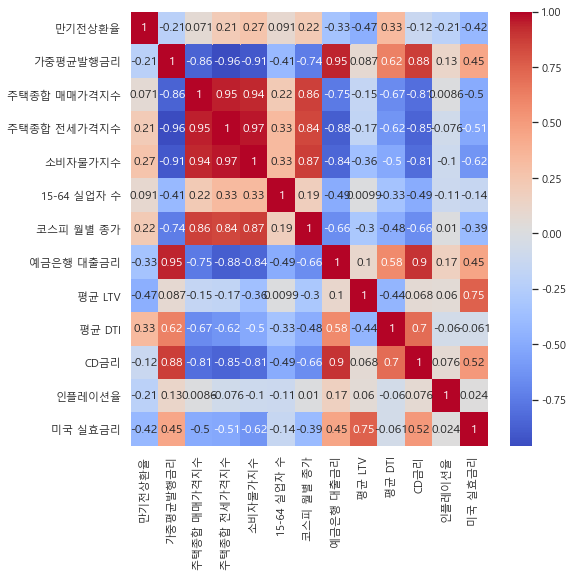

In [3]:
# 히트맵을 위한 라이브러리 호출
import matplotlib.pyplot as plt
import seaborn as sns

# 히트맵 드로잉
sns.set(rc={'figure.figsize':(8,8)}) ## 히트맵 크기 설정
plt.rc('font', family='Malgun Gothic') ## 한글 깨짐 설정
sns.heatmap(data_a.corr(), annot=True, cmap='coolwarm') ## 히트맵 그리기
plt.rcParams['axes.unicode_minus'] = False ## 마이너스 부호 깨지는 걸 방지함
plt.show()

In [4]:
# 모든 컬럼VIF 확인
from test_package import find_vif
find_vif(data_a)

      VIF Factor     features
0   39764.936526      소비자물가지수
1    8546.100893       평균 LTV
2    7353.008523    코스피 월별 종가
3    5235.294113       평균 DTI
4    4861.663748  15-64 실업자 수
5    2483.070369  주택종합 전세가격지수
6    1654.843408  주택종합 매매가격지수
7     869.053549     가중평균발행금리
8     720.877363    예금은행 대출금리
9      78.405715         CD금리
10     19.393834      미국 실효금리
11     12.094371       만기전상환율
12      1.568798       인플레이션율


### Scaling
- Standard : 데이터를 표준정규분포 모양으로 만듬 -> 데이터 특성을 반영 못 하니까 못 씀
- Robuster : 아웃라이어를 없애버림 -> 막판에 만기전상환율이 튀는 걸 살리는 게 맞는 것 같음 -> 못 씀
- Min-Max : 아웃라이어 살리고 데이터 분포 살림 (-> 남는 게 이거 뿐)

In [5]:
# Min - Max Scaler
from sklearn.preprocessing import MinMaxScaler

data_c = data_a.copy().reset_index()
scaler = MinMaxScaler()
mm_temp = data_c.drop(columns=['기준월','만기전상환율'])
colnames = data_c.columns.drop(['기준월','만기전상환율'])

mm_data = scaler.fit_transform(mm_temp)

mm_result = pd.DataFrame(mm_data, columns=colnames)

In [6]:
# # Min-Max 스케일링 잘 됐는지 확인
# mm_result.describe()

### 피처, 타겟 설정

In [7]:
# 최적의 알파값을 찾기 전에 피처랑 타겟 설정
## 주요 요인 별로 나눈 이유 -> 각 상관관계가 너무 높아서
    #### !!추가할 변수들 더 생기면 여기에 추가하기!!
    
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score

target = data_a['만기전상환율'] ### 타깃

feature_data = mm_result        ### ALL

## 변수 각각 분석
feature_data_A = mm_result[['가중평균발행금리', '예금은행 대출금리', 'CD금리']]         ### 금리 요인(CD포함)
feature_data_AA = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']] ### 금리 요인(CD미포함)
feature_data_B = mm_result[['주택종합 매매가격지수', '평균 LTV', '평균 DTI']]           ### 부동산 요인
feature_data_C = mm_result[['15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]     ### 거시경제 요인
##---------------------------------------------------------------------------------------------

## 변수 합쳐서 분석
feature_data2_A = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리']]                                 ### 금리 요인(CD미포함)
feature_data2_B = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI']] ### 금리 요인 + 부동산 요인
feature_data2_C = mm_result[['가중평균발행금리', '예금은행 대출금리', '미국 실효금리', '주택종합 매매가격지수', '평균 LTV', '평균 DTI'
                            , '15-64 실업자 수', '인플레이션율', '코스피 월별 종가']]                                   ### 금리 요인 + 부동산 요인 + 거시경제 요인
##---------------------------------------------------------------------------------------------



In [ ]:
# VIF after Min-Max Scaling
## 카테고리끼리 VIF 비교

from test_package import find_vif

datas = [feature_data
        , feature_data_A, feature_data_AA, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C]
num = range(1,len(datas)+1)

### >> for문에 들어가는 변수의 위치(feature_data는 0)도 VIF출력할 때 번호 붙여서 같이 출력(근데 번호는 1부터 시작하고 싶음)
### 요인들 번호 매기고 VIF 출력
for num, data in zip(num, datas):
        # print("번호", num)
        print(f'번호 {num}')
        find_vif(data)
        print(' ')

### 최적의 알파값 구하기

In [91]:
# 각 변수 요인들 끼리만
## GridSearchCV 수행하는 함수를 담은 패키지 로드
from test_package import find_best_alpha

## 75% 수준의 데이터만 가지고 돌렸을 때
datas = [feature_data
        , feature_data_A, feature_data_AA, feature_data_B, feature_data_C
        , feature_data2_A, feature_data2_B, feature_data2_C]
types = ['ridge', 'lasso', 'elastic']


### >> 모델 하나의 알파값을 구하는데 포문으로 모든 요인변수 돌리고나서 다 끝나면 다른 모델 넣어서 반복
### 모든 변수를 모델에 대입했을 때 최적의 앒파값 구하기
for type in types:
    print(" ")
    print(type)

    for data in datas:
        find_best_alpha(type, data[:161], target[:161])

### 이제 이걸 데이터프레임으로 옮기고싶음

 
ridge
Type : ridge | {'alpha': 1.0} | MSE : 0.33644984738526096 | RMSE: 0.5800429702920818
Type : ridge | {'alpha': 1.0} | MSE : 0.4843211261090408 | RMSE: 0.6959318401316618
Type : ridge | {'alpha': 1.0} | MSE : 0.33980303045388716 | RMSE: 0.5829262650231907
Type : ridge | {'alpha': 1.0} | MSE : 2.3037020391880585 | RMSE: 1.5177951242470304
Type : ridge | {'alpha': 0.24} | MSE : 1.8011650392986436 | RMSE: 1.342074900778136
Type : ridge | {'alpha': 1.0} | MSE : 0.33980303045388716 | RMSE: 0.5829262650231907
Type : ridge | {'alpha': 1.0} | MSE : 0.21879274546072672 | RMSE: 0.4677528679342615
Type : ridge | {'alpha': 1.0} | MSE : 0.17812490536673786 | RMSE: 0.4220484632915252
 
lasso
Type : lasso | {'alpha': 0.01} | MSE : 0.09763324607683654 | RMSE: 0.3124631915551599
Type : lasso | {'alpha': 0.02} | MSE : 0.3653415107355624 | RMSE: 0.6044348688945422
Type : lasso | {'alpha': 0.02} | MSE : 0.277289799411516 | RMSE: 0.5265831362771847
Type : lasso | {'alpha': 0.04} | MSE : 2.06070992173

### 요인 별 RMSE 스코어 계산

In [22]:
# 각 변수 요인들 끼리 RMSE 스코어 계산
import test_package as tp
# Hand-made Function
# type = 'lasso', 'ridge', 'elastic'

####### >> feature_data_A 중에서 
print('금리 요인')
tp.score_checker('ridge', feature_data_A[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data_A[:161], target[:161], 0.02)
tp.score_checker('elastic', feature_data_A[:161], target[:161], 0.24)

print('\n부동산 요인\n')
tp.score_checker('ridge', feature_data_B[:161], target[:161], 1.0)
tp.score_checker('lasso', feature_data_B[:161], target[:161], 0.04)
tp.score_checker('elastic', feature_data_B[:161], target[:161], 0.01)

print('\n거시경제 요인')
tp.score_checker('ridge', feature_data_C[:161], target[:161], 0.27)
tp.score_checker('lasso', feature_data_C[:161], target[:161], 0.02)
tp.score_checker('elastic', feature_data_C[:161], target[:161], 0.01)

# 전반적으로 2번째 폴드가 점수는 좋아보임
# 전반적으로 1.3 ~ 1.4 스코어..


# 각 변수 요인들 끼리만
### Type : ridge | {'alpha': 1.0} | MSE : 0.2874325085464655 | RMSE: 0.5361273249392028
### Type : ridge | {'alpha': 1.0} | MSE : 0.4843211261090438 | RMSE: 0.6959318401316639
### Type : ridge | {'alpha': 1.0} | MSE : 2.303702039188056 | RMSE: 1.5177951242470296
### Type : ridge | {'alpha': 0.24} | MSE : 1.8011650392986471 | RMSE: 1.3420749007781374
###------------------------------------------------------------------------------------------

### Type : lasso | {'alpha': 0.01} | MSE : 0.09763323766117012 | RMSE: 0.3124631780885071
### Type : lasso | {'alpha': 0.02} | MSE : 0.36534151073556403 | RMSE: 0.6044348688945436
### Type : lasso | {'alpha': 0.04} | MSE : 2.0607099217398903 | RMSE: 1.4355173010938915
### Type : lasso | {'alpha': 0.01} | MSE : 1.9356329844828863 | RMSE: 1.3912702772944179
###------------------------------------------------------------------------------------------

### Type : elastic | {'alpha': 0.01} | MSE : 0.058333389447388174 | RMSE: 0.24152306193692596
### Type : elastic | {'alpha': 0.01} | MSE : 0.450128142753749 | RMSE: 0.67091589842077
### Type : elastic | {'alpha': 0.02} | MSE : 2.253402311844675 | RMSE: 1.5011336755414806
### Type : elastic | {'alpha': 0.01} | MSE : 1.9762840605631233 | RMSE: 1.4058037062702329
###------------------------------------------------------------------------------------------


금리 요인
Alpha : 1.0
Ridge Negative MSE score : [0.724 0.063 0.778 4.679 5.432]
Ridge RMSE scores : [0.851 0.25  0.882 2.163 2.331]
Ridge AVG RMSE : 1.296

Alpha : 0.02
Lasso Negative MSE score : [0.694 0.092 0.757 4.794 4.898]
Lasso RMSE scores : [0.833 0.303 0.87  2.19  2.213]
Lasso AVG RMSE : 1.282

Alpha : 0.24
Elastic Negative MSE score : [1.693 1.325 0.639 7.01  1.281]
Elastic RMSE scores : [1.301 1.151 0.799 2.648 1.132]
Elastic AVG RMSE : 1.406

부동산 요인

Alpha : 1.0
Ridge Negative MSE score : [0.361 1.35  0.292 5.486 2.908]
Ridge RMSE scores : [0.601 1.162 0.54  2.342 1.705]
Ridge AVG RMSE : 1.270

Alpha : 0.04
Lasso Negative MSE score : [0.681 1.232 0.307 6.162 3.007]
Lasso RMSE scores : [0.825 1.11  0.554 2.482 1.734]
Lasso AVG RMSE : 1.341

Alpha : 0.01
Elastic Negative MSE score : [0.375 1.361 0.276 5.548 3.09 ]
Elastic RMSE scores : [0.613 1.167 0.525 2.355 1.758]
Elastic AVG RMSE : 1.284

거시경제 요인
Alpha : 0.27
Ridge Negative MSE score : [0.435 1.185 0.581 5.608 4.735]
Ridge RM

In [23]:
# 변수 합한 요인 별 RMSE 스코어 계산

import test_package as tp
# Hand-made Function
# type = 'lasso', 'ridge', 'elastic'

print('금리 요인')
tp.score_checker('ridge', feature_data2_A[:171], target[:171], 0.56)
tp.score_checker('lasso', feature_data2_A[:171], target[:171], 1.0)
tp.score_checker('elastic', feature_data2_A[:171], target[:171], 1.0)

print('\n금리+부동산 요인\n')
tp.score_checker('ridge', feature_data2_B[:171], target[:171], 1.0)
tp.score_checker('lasso', feature_data2_B[:171], target[:171], 0.03)
tp.score_checker('elastic', feature_data2_B[:171], target[:171], 0.02)

print('\n금리+부동산+거시경제 요인')
tp.score_checker('ridge', feature_data2_C[:171], target[:171], 1.0)
tp.score_checker('lasso', feature_data2_C[:171], target[:171], 0.02)
tp.score_checker('elastic', feature_data2_C[:171], target[:171], 0.01)

# 전반적으로 2번째 폴드가 점수는 좋아보임
# 전반적으로 1.3 ~ 1.4 스코어..

# 각 변수 요인들 합쳐서
# Type : ridge | {'alpha': 1.0} | MSE : 0.2874325085464655 | RMSE: 0.5361273249392028
# Type : ridge | {'alpha': 0.56} | MSE : 0.38123749728798745 | RMSE: 0.6174443272781663
# Type : ridge | {'alpha': 1.0} | MSE : 0.22841150280048467 | RMSE: 0.47792416009287986
# Type : ridge | {'alpha': 1.0} | MSE : 0.1428708580558653 | RMSE: 0.3779826160762758
###------------------------------------------------------------------------------------------

# Type : lasso | {'alpha': 0.01} | MSE : 0.09763323766117012 | RMSE: 0.3124631780885071
# Type : lasso | {'alpha': 0.01} | MSE : 0.3594885820597966 | RMSE: 0.5995736669165822
# Type : lasso | {'alpha': 0.03} | MSE : 0.10800538777063853 | RMSE: 0.3286417316328505
# Type : lasso | {'alpha': 0.02} | MSE : 0.08653503043371216 | RMSE: 0.29416837089278
###------------------------------------------------------------------------------------------

# Type : elastic | {'alpha': 0.01} | MSE : 0.058333389447388174 | RMSE: 0.24152306193692596
# Type : elastic | {'alpha': 0.01} | MSE : 0.38722074452426836 | RMSE: 0.6222706360774775
# Type : elastic | {'alpha': 0.02} | MSE : 0.1022539047792405 | RMSE: 0.3197716447392428
# Type : elastic | {'alpha': 0.01} | MSE : 0.030368397944088698 | RMSE: 0.1742653090666318

금리 요인
Alpha : 0.56
Ridge Negative MSE score : [0.703 0.061 0.812 4.515 5.569]
Ridge RMSE scores : [0.838 0.248 0.901 2.125 2.36 ]
Ridge AVG RMSE : 1.294

Alpha : 1.0
Lasso Negative MSE score : [2.066 1.677 0.606 7.01  0.928]
Lasso RMSE scores : [1.437 1.295 0.778 2.648 0.963]
Lasso AVG RMSE : 1.424

Alpha : 1.0
Elastic Negative MSE score : [2.066 1.677 0.606 7.01  0.928]
Elastic RMSE scores : [1.437 1.295 0.778 2.648 0.963]
Elastic AVG RMSE : 1.424

금리+부동산 요인

Alpha : 1.0
Ridge Negative MSE score : [0.814 0.239 0.239 4.033 6.558]
Ridge RMSE scores : [0.902 0.489 0.489 2.008 2.561]
Ridge AVG RMSE : 1.290

Alpha : 0.03
Lasso Negative MSE score : [0.678 0.135 0.429 4.895 5.018]
Lasso RMSE scores : [0.823 0.368 0.655 2.213 2.24 ]
Lasso AVG RMSE : 1.260

Alpha : 0.02
Elastic Negative MSE score : [0.546 0.194 0.26  4.466 5.147]
Elastic RMSE scores : [0.739 0.44  0.51  2.113 2.269]
Elastic AVG RMSE : 1.214

금리+부동산+거시경제 요인
Alpha : 1.0
Ridge Negative MSE score : [0.803 0.217 0.205 3.957 7.582]


In [17]:
####### >> 간단정리: 모든 요인들을 최적의 알파값과 함께 모델에 넣었을 때 그 모델의 N-MAE score, MSE score, AVG RMSE 까지 출력
####### > 모든 요인들을 넣고 모든 모델들을 넣는데 타켓은 고정, 알파값은 요인-모델 따라 달라짐
####### > 알파값 0.1이라고 고정하면 구할 수 있음
####### > 근데 알파값은 모델따라 달라지니까ㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜ
####### > 함수로 만들어서 알파만 수동으로 입력하게 해야하나ㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜㅜ 머리터져ㅕㅕㅕㅕㅕㅕㅕㅕㅕㅕㅕ악!!!!!!!!!!!!
####### > 근데 알파만 입력하게 되면 입력 값만 바뀌는 거지 모델에 따라 알파는 다 똑같이 됨 -> 원점으로 돌아감 ㅠㅠㅠㅠㅠㅠㅠ
####### > 요인변수랑 모델이랑 알파랑 동시에 만족하는 값을 찾아야하는데,, 
####### > **다시 정리하면 이 요인변수에 적합한 모델을 돌리는데 그 적합한 값은 알파값임**
####### > 그럼 그냥 오빠가 만든 함수 그대로 쓰는게 나을수도

# def score_checker(type, data, target, alpha):

datass = [feature_data, feature_data_A, feature_data_AA, feature_data_B, feature_data_C
            , feature_data2_A, feature_data2_B, feature_data2_C]
num = range(1,len(datass)+1)

typess = ['ridge', 'lasso', 'elastic']
targetss = [target]
# alphass = 0.1

def enter_alpha(alphass):
    datass = [feature_data, feature_data_A, feature_data_AA, feature_data_B, feature_data_C
            , feature_data2_A, feature_data2_B, feature_data2_C]
    num = range(1,len(datass)+1)

    typess = ['ridge', 'lasso', 'elastic']
    targetss = [target]
    # alphass = 0.1

    for num, data11 in zip(num, datass):
        print("-----------------------------------------------------------------------------------------------")
        print(f'번호 {num}')
        # print(f'모델 {data11}')
        ###### >> 난 for문에 들어가는 요인 이름 뽑고싶은데 데이터가 나와버림

        for type in typess:
            print(f'모델: {type}')

            if type == 'ridge':
                type = Ridge(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Ridge Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Ridge RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Ridge AVG RMSE : {avg_rmse:.3f}\n')

            elif type == 'lasso':
                type = Lasso(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Lasso Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Lasso RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Lasso AVG RMSE : {avg_rmse:.3f}\n')

            elif type == 'elastic':
                type = ElasticNet(alphass)
                mse_score = cross_val_score(type, data11[:161], target[:161], scoring="neg_mean_squared_error", cv=5)
                rmse_score = np.sqrt(-1 * mse_score)
                avg_rmse = np.mean(rmse_score)

                print(f'Alpha : {alphass}')
                print(f'Elastic Negative MSE score : {np.abs(np.round(mse_score, 3))}')
                print(f'Elastic RMSE scores : {np.round(rmse_score, 3)}')
                print(f'Elastic AVG RMSE : {avg_rmse:.3f}')

            else:
                print(f'Check the type values')

enter_alpha(0.01)

-----------------------------------------------------------------------------------------------
번호 1
모델: ridge
Alpha : 0.01
Ridge Negative MSE score : [1.266 0.183 0.413 1.007 3.556]
Ridge RMSE scores : [1.125 0.427 0.643 1.003 1.886]
Ridge AVG RMSE : 1.017

모델: lasso
Alpha : 0.01
Lasso Negative MSE score : [0.736 0.051 0.071 1.077 3.373]
Lasso RMSE scores : [0.858 0.226 0.266 1.038 1.837]
Lasso AVG RMSE : 0.845

모델: elastic
Alpha : 0.01
Elastic Negative MSE score : [0.561 0.097 0.078 1.159 3.694]
Elastic RMSE scores : [0.749 0.311 0.279 1.077 1.922]
Elastic AVG RMSE : 0.867
-----------------------------------------------------------------------------------------------
번호 2
모델: ridge
Alpha : 0.01
Ridge Negative MSE score : [1.038 0.357 0.559 1.366 3.156]
Ridge RMSE scores : [1.019 0.598 0.748 1.169 1.776]
Ridge AVG RMSE : 1.062

모델: lasso
Alpha : 0.01
Lasso Negative MSE score : [0.732 0.138 0.423 1.43  3.348]
Lasso RMSE scores : [0.856 0.372 0.65  1.196 1.83 ]
Lasso AVG RMSE : 0.981

모

### 예측

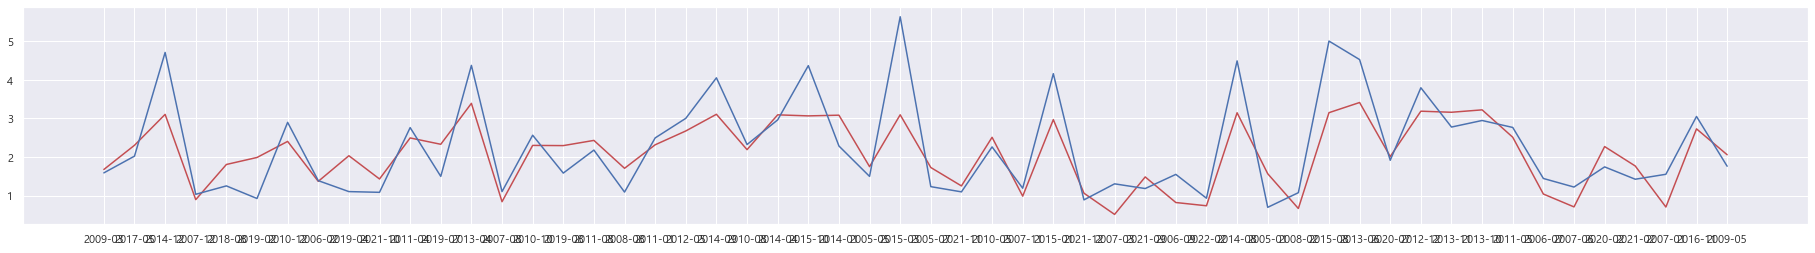

In [19]:
# 예측 그래프
## length -> 214 (60% 0~128, 20% 129~171, 20% 172~214)

## 변수 각각 요인 데이터
## feature_data_A : 금리 요인
## feature_data_B : 부동산 요인
## feature_data_C : 거시경제 요인

## 변수 합한 요인 데이터
## feature_data2_A : 금리 요인
## feature_data2_B : 금리 + 부동산 요인
## feature_data2_C : 금리 + 부동산 + 거시경제 요인

## 모델 : Ridge, Lasso, ElasticNet

x_train, x_test, y_train, y_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)

p_model = ElasticNet(alpha=0.01, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

In [ ]:
# 예측 그래프
## length -> 214 (60% 0~128, 20% 129~171, 20% 172~214)

## 변수 각각 요인 데이터
## feature_data_A : 금리 요인
## feature_data_B : 부동산 요인
## feature_data_C : 거시경제 요인

## 변수 합한 요인 데이터
## feature_data2_A : 금리 요인
## feature_data2_B : 금리 + 부동산 요인
## feature_data2_C : 금리 + 부동산 + 거시경제 요인

## 모델 : Ridge, Lasso, ElasticNet

x_train, x_test, y_train, y_test = train_test_split(feature_data2_C, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

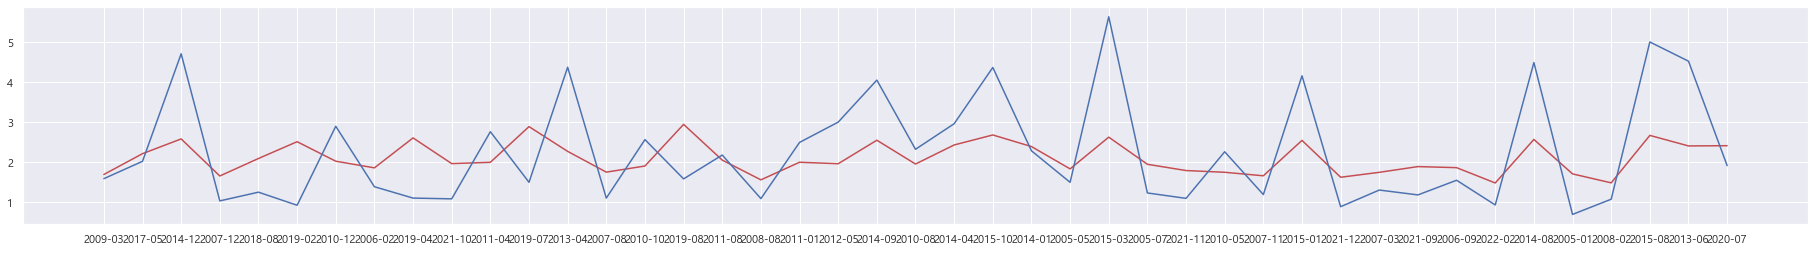

In [26]:
## 모델 : Ridge, Lasso, ElasticNet
x_train, x_test, y_train, y_test = train_test_split(feature_data_A, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

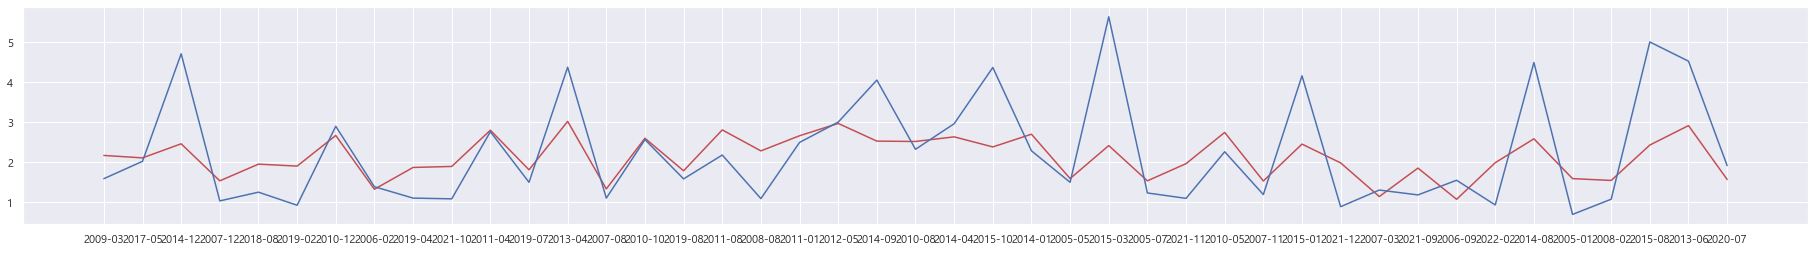

In [27]:
## 모델 : Ridge, Lasso, ElasticNet
x_train, x_test, y_train, y_test = train_test_split(feature_data_B, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

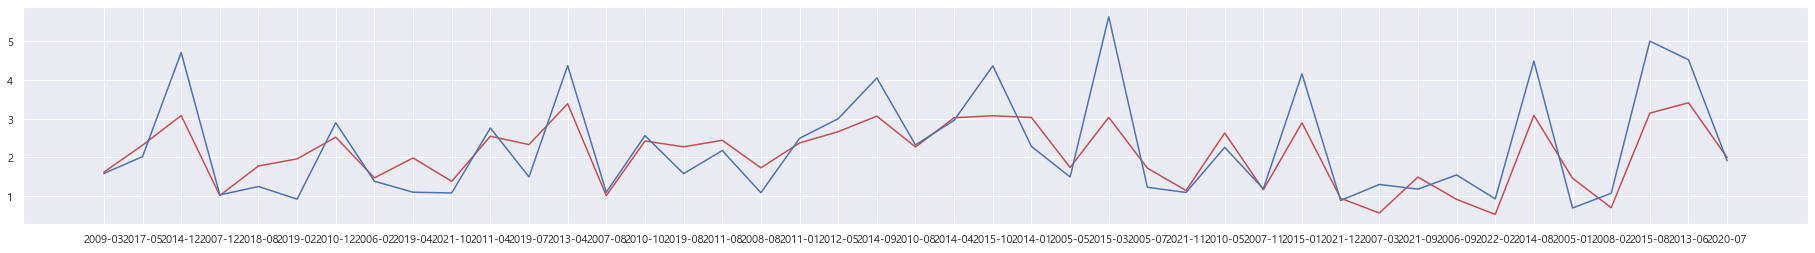

In [34]:
## 모델 : Ridge, Lasso, ElasticNet
x_train, x_test, y_train, y_test = train_test_split(feature_data2_C, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

In [20]:
# Train Set : Test Set = 75% : 25%
# Test SET 20%일 경우 코로나 시국 데이터가 좀 더 반영됨

## 변수 각각 요인 데이터
# feature_data_A : 금리 요인(CD O)
# feature_data_AA : 금리 요인(미국 O)
# feature_data_B : 부동산 요인
# feature_data_C : 거시경제 요인

## 변수 합한 요인 데이터
## feature_data2_A : 금리 요인
## feature_data2_B : 금리 + 부동산 요인
## feature_data2_C : 금리 + 부동산 + 거시경제 요인

###########################################
# 가장 잘 나온 모델로 예측이라는 걸 해봅시다 #
###########################################

xa_train, xa_test, ya_train, ya_test = train_test_split(feature_data_A, target, test_size=0.25, random_state=25)
xa_model = ElasticNet(alpha=0.03, random_state=25)
xa_model.fit(xa_train, ya_train)
xa_pred = xa_model.predict(xa_test)

xb_train, xb_test, yb_train, yb_test = train_test_split(feature_data_B, target, test_size=0.25, random_state=25)
xb_model = ElasticNet(alpha=0.02, random_state=25)
xb_model.fit(xb_train, yb_train)
xb_pred = xb_model.predict(xb_test)

xc_train, xc_test, yc_train, yc_test = train_test_split(feature_data_C, target, test_size=0.25, random_state=25)
xc_model = ElasticNet(alpha=0.01, random_state=25)
xc_model.fit(xc_train, yc_train)
xc_pred = xc_model.predict(xc_test)

xd_train, xd_test, yd_train, yd_test = train_test_split(feature_data, target, test_size=0.25, random_state=25)
xd_model = ElasticNet(alpha=0.03, random_state=25)
xd_model.fit(xd_train, yd_train)
xd_pred = xd_model.predict(xd_test)

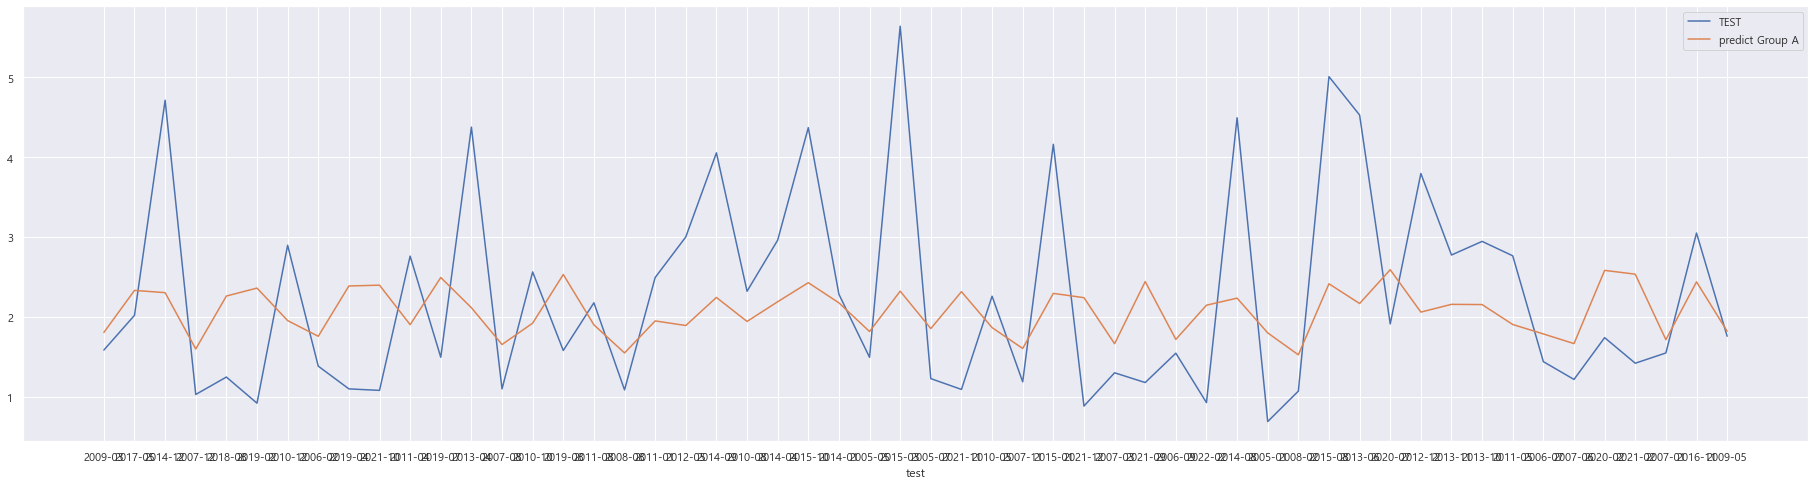

In [21]:
feature_data_X = feature_data_A[['예금은행 대출금리']]

xx_train, xx_test, yx_train, yx_test = train_test_split(feature_data_X, target, test_size=0.25, random_state=25)
xx_model = ElasticNet(alpha=0.03, random_state=25)
xx_model.fit(xx_train, yx_train)
xx_pred = xx_model.predict(xx_test)

fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(yx_test, label="TEST")
plt.plot(xx_pred, label="predict Group A")
plt.legend(loc='upper right')
plt.show()

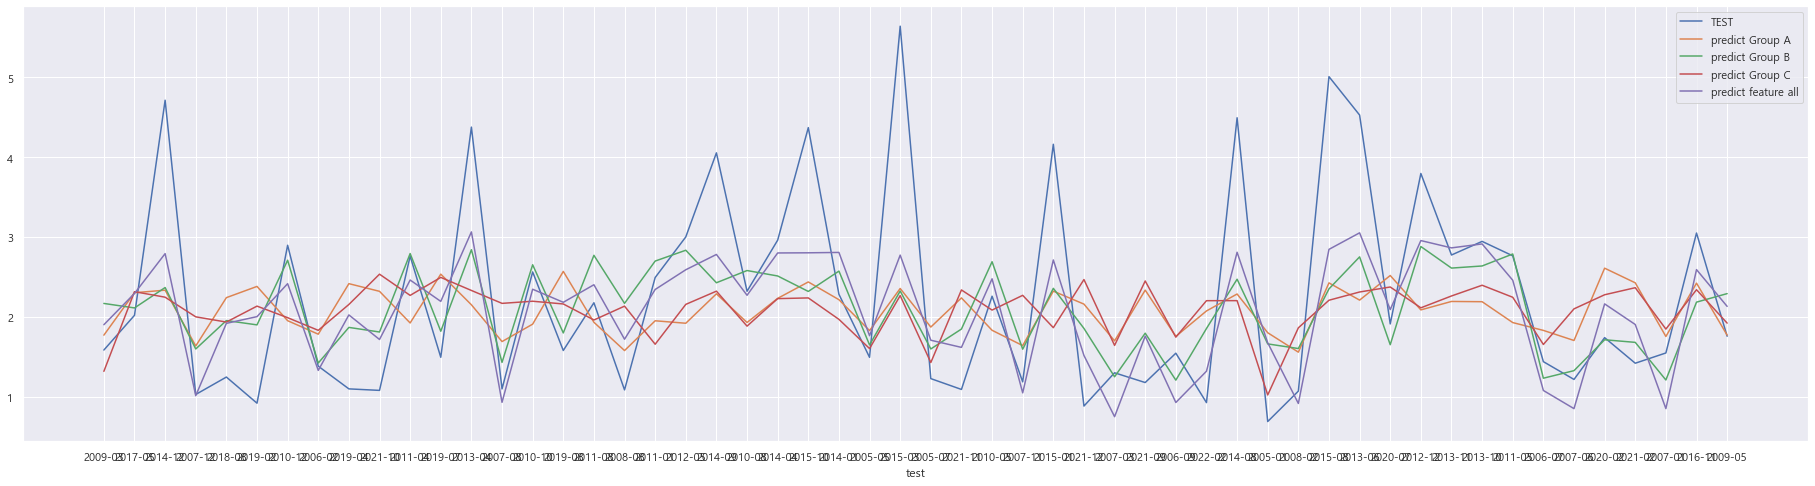

In [22]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(yd_test, label="TEST")
plt.plot(xa_pred, label="predict Group A")
plt.plot(xb_pred, label="predict Group B")
plt.plot(xc_pred, label="predict Group C")
plt.plot(xd_pred, label="predict feature all")

plt.legend(loc='upper right')
plt.show()

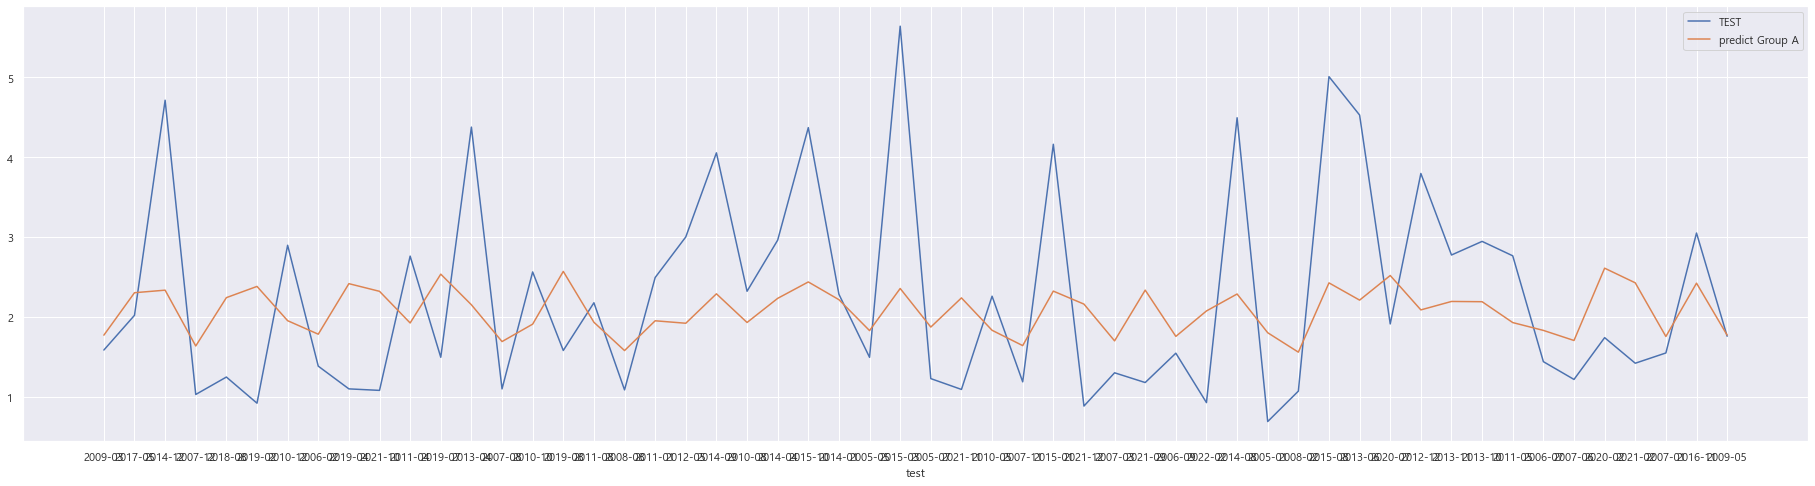

In [23]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(ya_test, label="TEST")
plt.plot(xa_pred, label="predict Group A")
plt.legend(loc='upper right')
plt.show()

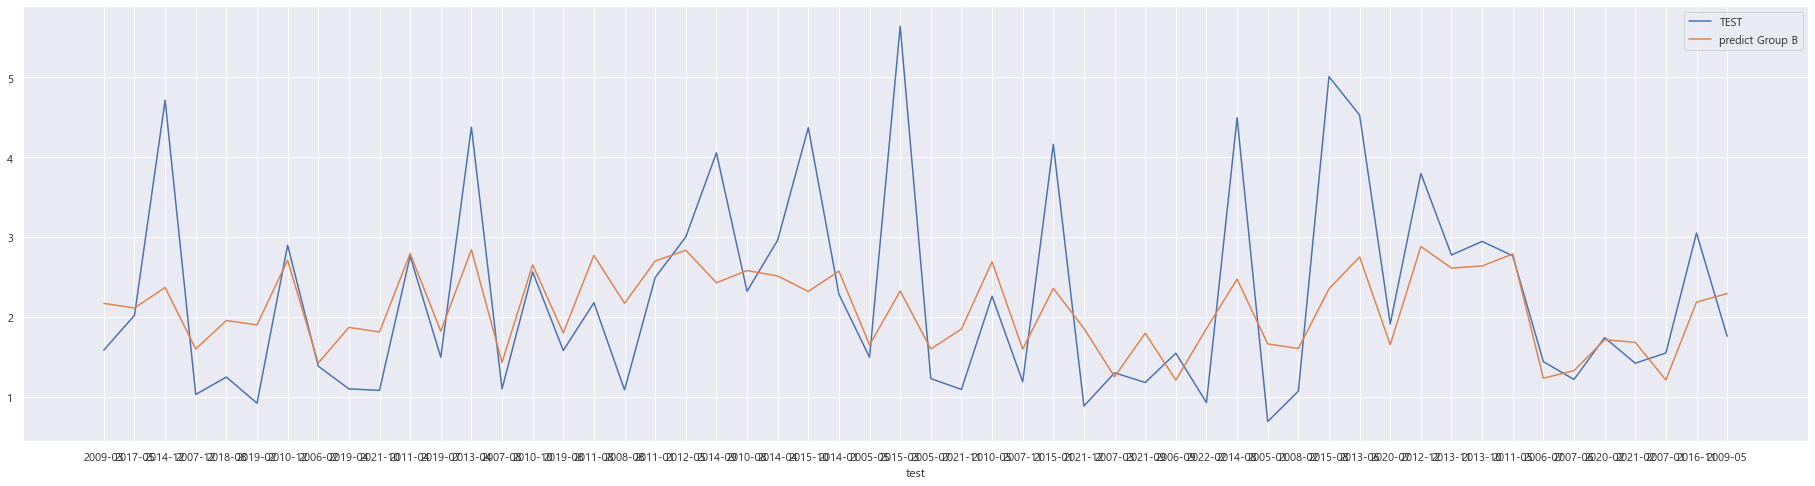

In [24]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(yb_test, label="TEST")
plt.plot(xb_pred, label="predict Group B")
plt.legend(loc='upper right')
plt.show()

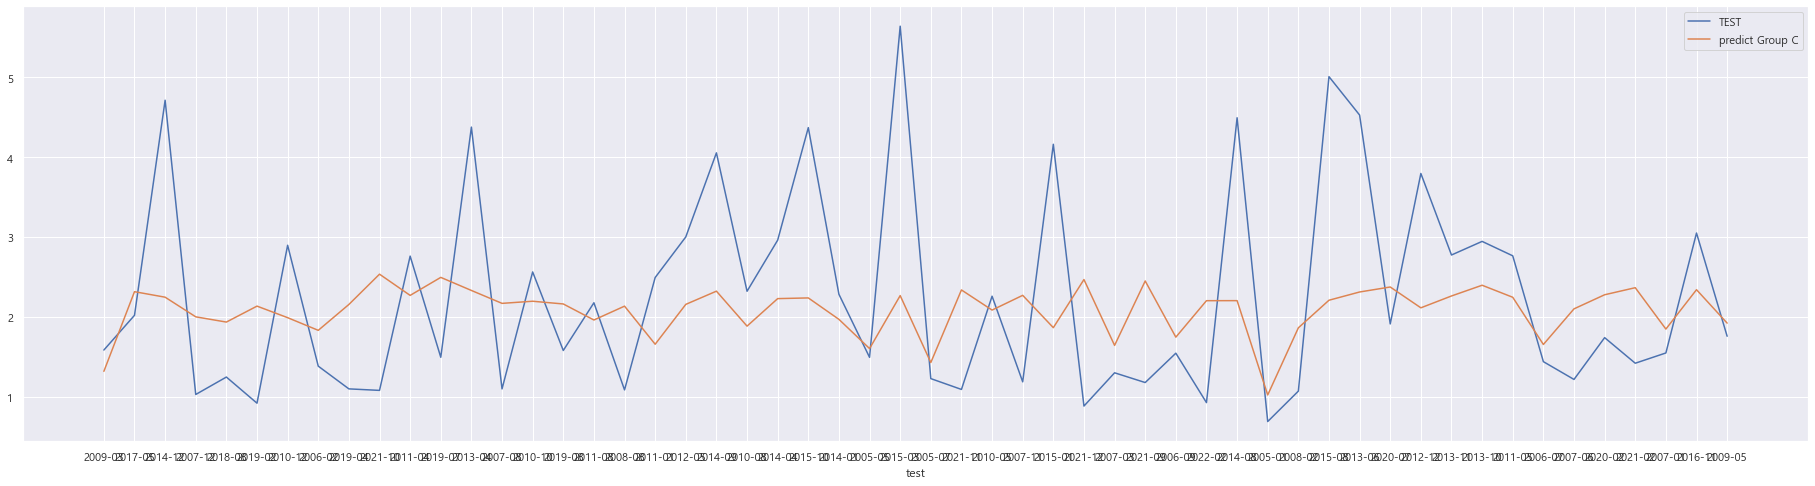

In [25]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(yc_test, label="TEST")
plt.plot(xc_pred, label="predict Group C")
plt.legend(loc='upper right')
plt.show()

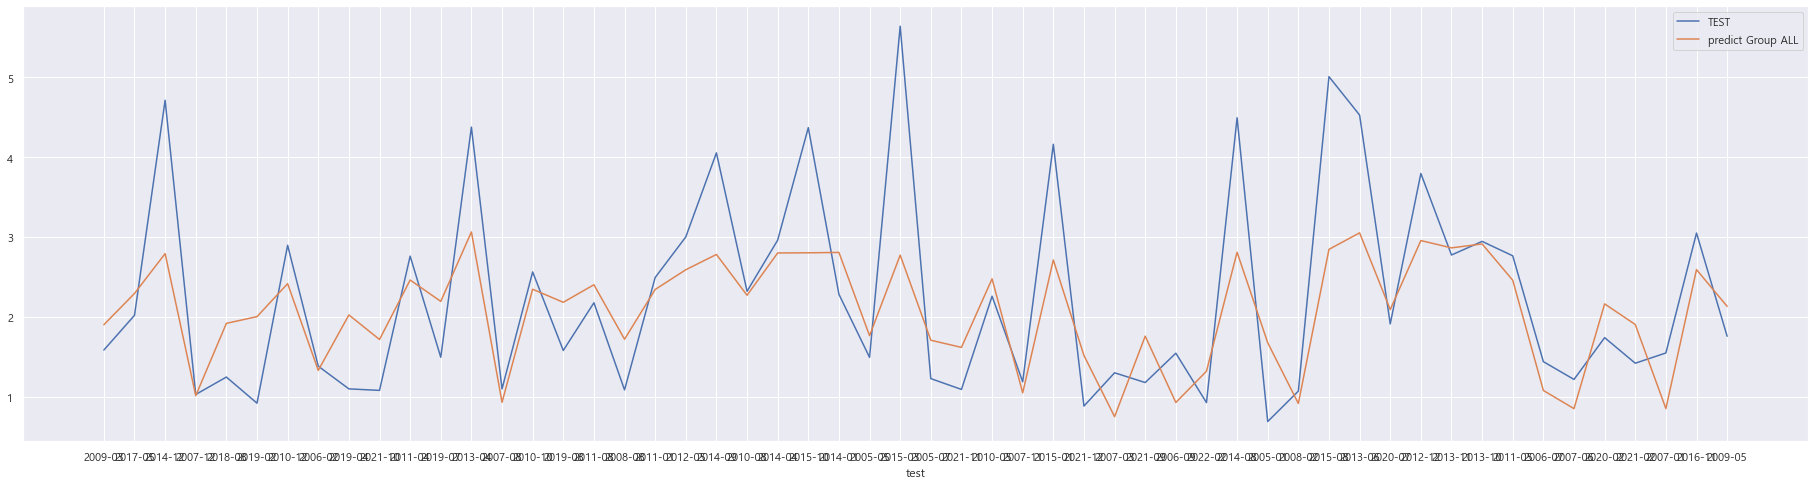

In [26]:
fig, axs = plt.subplots(1,1, figsize=(32,8))
plt.xlabel("test")
plt.plot(yd_test, label="TEST")
plt.plot(xd_pred, label="predict Group ALL")
plt.legend(loc='upper right')
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, accuracy_score

mse_x = mean_squared_error(yx_test, xc_pred)
rmse_x = mse_x ** 0.5

mse_a = mean_squared_error(ya_test, xa_pred)
rmse_a = mse_a ** 0.5

mse_b = mean_squared_error(yb_test, xb_pred)
rmse_b = mse_b ** 0.5

mse_c = mean_squared_error(yc_test, xc_pred)
rmse_c = mse_c ** 0.5

mse_all = mean_squared_error(yd_test, xd_pred)
rmse_all = mse_all ** 0.5


print(f'금리 단독 요인 RMSE : {rmse_x:.3f}')
print(f'금리 혼합 요인 RMSE : {rmse_a:.3f}')
print(f'부동산 요인 RMSE : {rmse_b:.3f}')
print(f'거시경제 요인 RMSE : {rmse_c:.3f}')
print(f'전체 요인 RMSE : {rmse_all:.3f}')

금리 단독 요인 RMSE : 1.231
금리 혼합 요인 RMSE : 1.202
부동산 요인 RMSE : 1.015
거시경제 요인 RMSE : 1.231
전체 요인 RMSE : 0.864


In [ ]:
# 생각해볼 것
# 1. 상대적으로 RMSE가 좋지 않다고 판된되는 그룹들을 대상으로 앙상블 수행
# 2. 금리 요인을 시작으로 하나하나 추가하면서 다시 분석해보기 (+ 다른 feature 찾기)
# 3. 만기 전 상환율을 ARIMA로 예측이 가능한... 거 맞아?

In [ ]:
# 최적의 알파값을 찾기 전에 피처링 타겟 설정
mm_result3 = mm_result.copy()

## ALL
feature_data3 = mm_result2

## 가중평균발행금리 요인 
feature_data3_A = mm_result2[['가중평균발행금리']]

## '예금은행 대출금리' 요인
feature_data3_B = mm_result2[['예금은행 대출금리']]

## CD금리 요인
feature_data3_C = mm_result2[['가중평균발행금리', '예금은행 대출금리']]

target = data_a['만기전상환율']

## 주요 요인 별로 나눈 이유 -> 각 상관관계가 너무 높아서

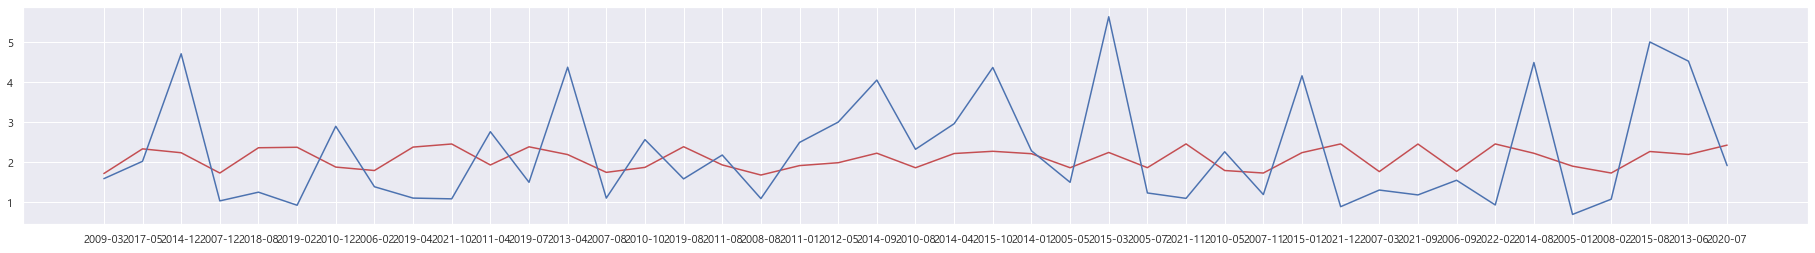

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_data3_A, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

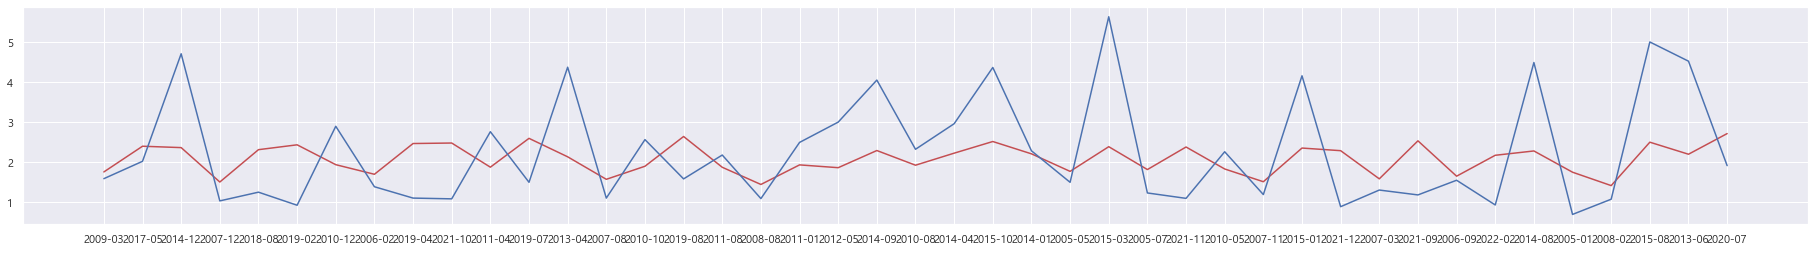

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_data3_B, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

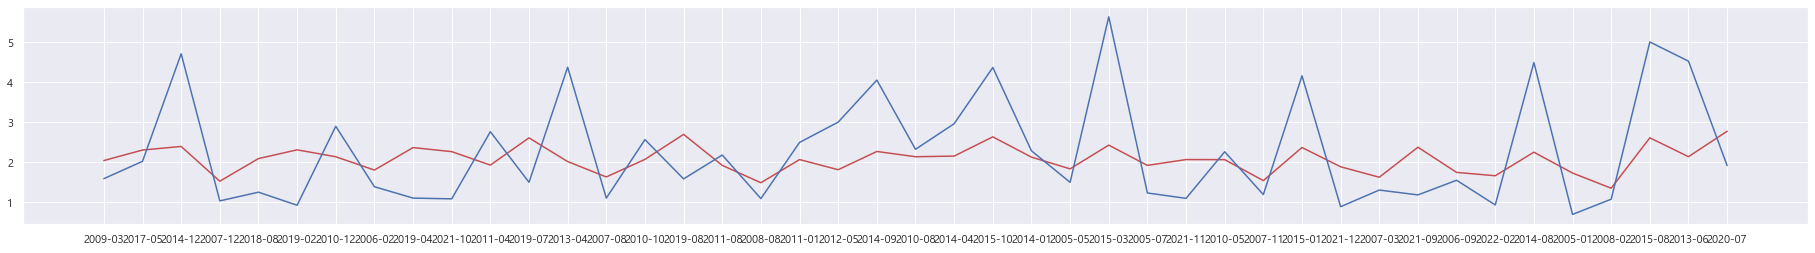

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_data3_C, target, test_size=0.2, random_state=25)

p_model = Ridge(alpha=1.0, random_state=25)
p_model.fit(x_train, y_train)
p_pred = p_model.predict(x_test)

plt.figure(figsize=(32,4))
plt.plot(p_pred, c='r')
#plt.plot(y_train)
plt.plot(y_test)
plt.show()

## 코드 중복된거 -> 함수 다시 만들기
## 들어가는 피쳐들 개별적 쓰지 말고 리스트 정리
## 그래프 이쁘게 하자
## 